In [4]:
from NOAAStations import TidalStation
from DeviceModels import Turbine, calculate_power
from Calculator import maintenance, operation

from ipywidgets import widgets, interact, fixed
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
import scipy
import scipy.interpolate
from contextlib import redirect_stdout
figsize(12, 10)
sbn.set_context("talk", font_scale=1)


from collections import namedtuple


### Testing for the maintenance monte carlo simulation

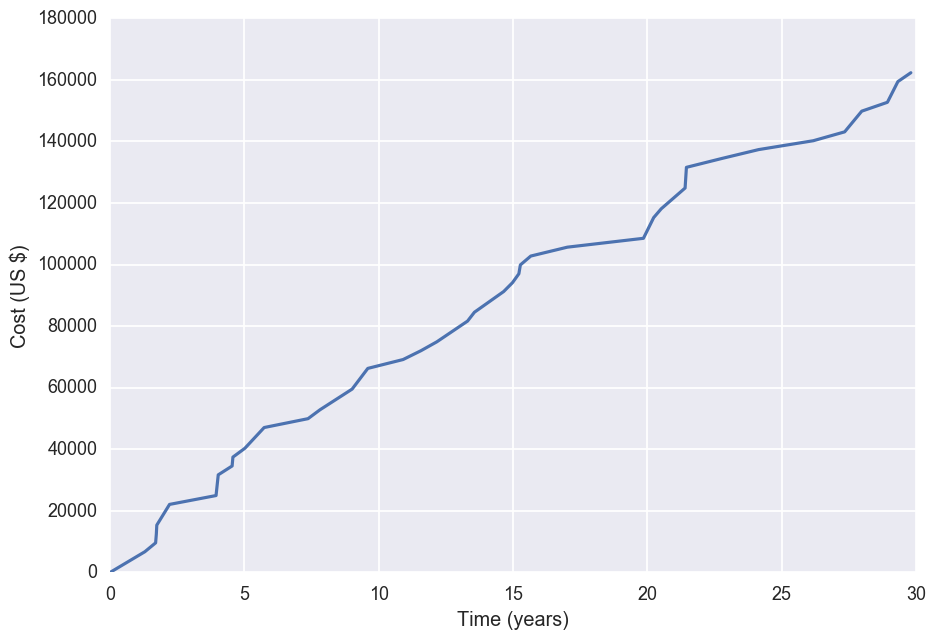

In [5]:
Maintenance_Rate = namedtuple('Parameter', 'partname minimal_rate midlevel_rate severe_rate minimal_cost midlevel_cost severe_cost number labor')

emergency_maintenance = [
    Maintenance_Rate('Blade', 0.042, 0.0273, 0.00007, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Others', 0.03, 0.0299, 0.00006, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Gear Box',0.2125, 0.0325, 0.0005, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Electricity Generator', 0.065, 0.0545, 0.0065, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Shaft', 0.002, 0.007, .001, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Brake', 0.0153, 0.0325, 0.0025, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Cable', 0.225, 0.09247, 0.000002, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Control system', 0.1, 0.1, 0.0001, 1., 4., 10., 1., 40.)
]

emergency_events = [maintenance.EmergencyMaintenance(
            e.minimal_rate, 
            e.midlevel_rate, 
            e.severe_rate,
            e.minimal_cost, 
            e.midlevel_cost, 
            e.severe_cost,
            e.number, 
            e.labor, 
            e.partname)
            for e in emergency_maintenance]

lifetime = 30.

time, emergency_maintenance_cost = maintenance.lifetimeMonteCarlo(lifetime, emergency_events, graph = True)

### Testing for the power output generation

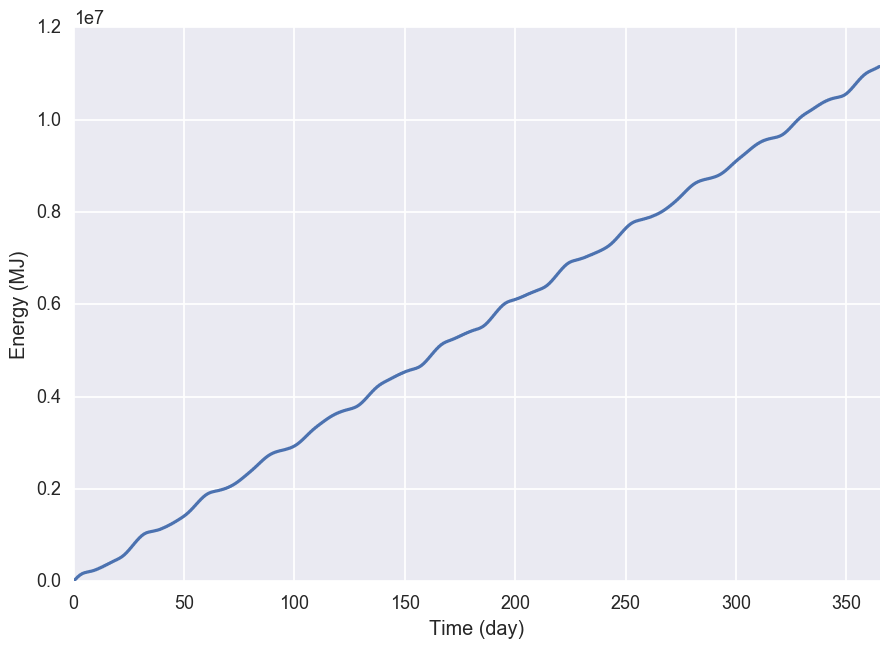

In [6]:
MCT = Turbine(1200., 0.1835, 3.55361367,  2.30706792,  1.05659521)
Sagamore = TidalStation(8447173)
results, times = calculate_power(Sagamore, MCT, 0, 0, 365*24*3600, 9.8, 3)

plt.plot(times/(24*3600), results/1000)
plt.xlim(0,365)
plt.ylabel('Energy (MJ)')
plt.xlabel('Time (day)')